# 2D SSN Model

In this notebook:
- training script for SSN model
- implementation of vmap
- new parameter added for extra synaptic GABA
- storing accuracy and params in csv file
- function to plot csv file data

GPU jax issues
- https://github.com/google/jax/issues/5231
- https://catid.io/posts/jax/

Imports

In [1]:
import matplotlib.pyplot as plt
import time, os, json
import pandas as pd
from scipy import stats 
from tqdm import tqdm
import seaborn as sns
import jax
from jax import random
from jax.config import config 
import jax.numpy as np
from jax import vmap
import pdb
import optax
import math
import csv
import time
#from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import numpy

from jax.lib import xla_bridge
print("jax backend {}".format(xla_bridge.get_backend().platform))
#config.update('jax_debug_nans', True)
from SSN_classes_jax import SSN2DTopoV1_AMPAGABA_ONOFF
from util import GaborFilter, BW_Grating, find_A, create_gabor_filters, create_gratings, param_ratios, plot_results, create_data

#initialize key
key = random.PRNGKey(9)

jax backend cpu


In [2]:
from platform import python_version
print(python_version())

3.8.10


### Parameters to define

1. STIMULI PARAMETERS

In [3]:
#Gabor parameters 
sigma_g= 0.5
k = np.pi/(6*sigma_g)

#Stimuli parameters
ref_ori = 55
offset = 5

#Assemble parameters in dictionary
general_pars = dict(k=k , edge_deg=3.2,  degree_per_pixel=0.05)
stimuli_pars = dict(outer_radius=3, inner_radius=2.5, grating_contrast=0.8, std = 15, jitter_val = 5)
stimuli_pars.update(general_pars)

2. MODEL PARAMETERS

In [4]:
#Network parameters
class ssn_pars():
    n = 2
    k = 0.04
    tauE = 30 # in ms
    tauI = 10 # in ms~
    psi = 0.774
    tau_s = np.array([5, 7, 100]) #in ms, AMPA, GABA, NMDA current decay time constants
    

#Grid parameters
class grid_pars():
    gridsize_Nx = 9 # grid-points across each edge # gives rise to dx = 0.8 mm
    gridsize_deg = 2 * 1.6 # edge length in degrees
    magnif_factor = 2  # mm/deg
    hyper_col = 0.8 # mm   
    sigma_RF = 0.4 # deg (visual angle)

# Caleb's params for the full (with local) model:
Js0 = [1.82650658, 0.68194475, 2.06815311, 0.5106321]
gE, gI = 0.57328625, 0.26144141

sigEE, sigIE = 0.2, 0.40
sigEI, sigII = .09, .09
#sigEI, sigII = .2, .2
conn_pars = dict(
    PERIODIC = False,
    p_local = [.4, 0.7], # [p_local_EE, p_local_IE],
    sigma_oris = 1000) # sigma_oris


make_J2x2 = lambda Jee, Jei, Jie, Jii: np.array([[Jee, -Jei], [Jie,  -Jii]]) * np.pi * ssn_pars.psi
J_2x2 = make_J2x2(*Js0)
s_2x2 = np.array([[sigEE, sigEI],[sigIE, sigII]])

#Parameters exclusive to Gabor filters
filter_pars = dict(sigma_g = sigma_g, conv_factor = grid_pars.magnif_factor)
filter_pars.update(general_pars) 


#Positive reparameterization
signs=np.array([[1, -1], [1, -1]])
logJ_2x2 =np.log(J_2x2*signs)
logs_2x2 = np.log(s_2x2)


#Excitatory and inhibitory constants for extra synaptic GABA
ssn=SSN2DTopoV1_AMPAGABA_ONOFF(ssn_pars=ssn_pars, grid_pars=grid_pars, conn_pars=conn_pars, filter_pars=filter_pars, J_2x2=J_2x2, s_2x2=s_2x2)
c_E = 5.0
c_I = 5.0

#Sigmoid parameters
N_neurons = 25

#key, _ = random.split(key)
#w_sig = random.normal(key, shape = (N_neurons,)) / np.sqrt(N_neurons)
w_sig = numpy.random.normal(size=(N_neurons,)) / np.sqrt(N_neurons)
#w_sig = np.zeros((N_neurons))
b_sig = 0.0

#Optimization pars
opt_pars = dict(logJ_2x2 = logJ_2x2, logs_2x2 = logs_2x2, w_sig = w_sig, b_sig=b_sig, c_E = c_E, c_I = c_I)

#Convergence parameters
conv_pars=dict(dt = 1, xtol = 1e-5, Tmax = 1000, verbose=False, silent=True)
w_sig

DeviceArray([-0.16348115,  0.10831803,  0.10980932,  0.04751688,
             -0.09632663,  0.17372838,  0.17184938,  0.12164329,
              0.07326243, -0.29520586, -0.12560898, -0.14514229,
              0.08606245, -0.05321167,  0.07593568,  0.19124335,
             -0.15578848,  0.15763792, -0.13026312,  0.14318082,
             -0.08020136,  0.5097683 , -0.28430697, -0.0323038 ,
             -0.01306708], dtype=float32)

In [5]:
np.linalg.norm(opt_pars['w_sig'])

DeviceArray(0.8680037, dtype=float32)

3. TRAINING PARAMETERS

In [21]:
#Name of results csv
home_dir = os.getcwd()
#Create directory for results
results_dir = os.path.join(home_dir, 'results')
if os.path.exists(results_dir) == False:
        os.makedirs(results_dir)
        
        
results_name = 'test_batch.csv' #SPECIFY NAME OF RESULTS FILE
if results_name == None:
    results_name = 'results.csv'

results_filename = os.path.join(results_dir, results_name)



In [6]:
#Number of epochs
epochs = 100
num_epochs_to_save = 21
epochs_to_save = np.linspace(1 ,epochs, num_epochs_to_save).astype(int)


## TRAINING

In [7]:
def create_data(stimuli_pars, number=100, offset = 5, ref_ori=55):
    
    '''
    Create data for given jitter and noise value for testing (not dataloader)
    '''
    data = create_gratings(ref_ori=ref_ori, number=number, offset=offset, **stimuli_pars)
    train_data = next(iter(DataLoader(data, batch_size=len(data), shuffle=False)))
    train_data['ref'] = train_data['ref'].numpy()
    train_data['target'] = train_data['target'].numpy()
    train_data['label'] = train_data['label'].numpy()
    
    return train_data


def save_params_dict(opt_pars, accuracy, epoch ):
    J_2x2, s_2x2 = exponentiate(opt_pars)
     
    save_params= dict(val_accuracy= accuracy, 
                J_EE= J_2x2[0,0], J_EI = J_2x2[0,1], 
                              J_IE = J_2x2[1,0], J_II = J_2x2[1,1], 
                s_EE= s_2x2[0,0], s_EI = s_2x2[0,1], 
                              s_IE = s_2x2[1,0], s_II = s_2x2[1,1],
                c_E = opt_pars['c_E'], c_I = opt_pars['c_I'], 
                 epoch = epoch, w_sig = opt_pars['w_sig'], b_sig=opt_pars['b_sig'])
    
    return save_params

def constant_to_vec(c_E, c_I):
    
    matrix_E = np.zeros((9,9))
    matrix_E = matrix_E.at[2:7, 2:7].set(c_E)
    vec_E = np.ravel(matrix_E)
    
    matrix_I = np.zeros((9,9))
    matrix_I = matrix_I.at[2:7, 2:7].set(c_I)
    vec_I = np.ravel(matrix_I)
    
    constant_vec = np.hstack((vec_E, vec_E, vec_I, vec_I))
    return constant_vec

def sigmoid(x):
    return 1/(1+np.exp(x))

def binary_loss(n, x):
    return - (n*np.log(x) + (1-n)*np.log(1-x))

def exponentiate(opt_pars):
    signs=np.array([[1, -1], [1, -1]]) 
    
    J_2x2 =np.exp(opt_pars['logJ_2x2'])*signs
    s_2x2 = np.exp(opt_pars['logs_2x2'])
    
    return J_2x2, s_2x2

def our_max(x, beta=1):
    max_val = np.log(np.sum(np.exp(x*beta)))/beta
    return max_val

def model(opt_pars, ssn_pars, grid_pars, conn_pars, train_data, filter_pars,  conv_pars, bernoulli, sig_noise, lambda_1=1, lambda_2=1, lambda_w = 1, lambda_b = 1):
    
    J_2x2, s_2x2 = exponentiate(opt_pars)
    
    #Initialise network
    ssn=SSN2DTopoV1_AMPAGABA_ONOFF(ssn_pars=ssn_pars, grid_pars=grid_pars, conn_pars=conn_pars, filter_pars=filter_pars, J_2x2=J_2x2, s_2x2=s_2x2)
    
    #Create vector using extrasynaptic constants
    constant_vector = constant_to_vec(opt_pars['c_E'], opt_pars['c_I'])
    
    #Apply Gabor filters to stimuli
    output_ref=np.matmul(ssn.gabor_filters, train_data['ref']) + constant_vector
    output_target=np.matmul(ssn.gabor_filters, train_data['target']) + constant_vector
    
    #Rectify output
    SSN_input_ref=np.maximum(0, output_ref)
    SSN_input_target=np.maximum(0, output_target)

    #Find the fixed point 
    x_ref, r_max_ref, avg_dx_ref = obtain_fixed_point(ssn, SSN_input_ref, conv_pars)
    x_target, r_max_target, avg_dx_target = obtain_fixed_point(ssn, SSN_input_target, conv_pars)
    
    #Add additional noise before sigmoid layer
    if sig_noise:
        delta_x = x_ref.ravel() - x_target.ravel() + sig_noise*numpy.random.normal(size=((x_target.ravel()).shape))
    else:
        delta_x = x_ref.ravel() - x_target.ravel() 
    
    #Apply sigmoid function - combine ref and target
    x = sigmoid( np.dot(opt_pars['w_sig'], (delta_x)) + opt_pars['b_sig'])

    #Calculate losses
    loss_binary=binary_loss(train_data['label'], x)
    loss_avg_dx = lambda_1*(avg_dx_ref + avg_dx_target)/2
    loss_r_max =  lambda_2*(r_max_ref + r_max_target)/2
    loss_w = lambda_w*np.linalg.norm(opt_pars['w_sig'])
    loss_b = lambda_b*(opt_pars['b_sig']**2)
    
    #Combine all losses
    loss = loss_binary + lambda_1*(avg_dx_ref + avg_dx_target)/2 + lambda_2*(r_max_ref + r_max_target)/2 + lambda_w*np.linalg.norm(opt_pars['w_sig']) + lambda_b*(opt_pars['b_sig']**2)
    all_losses = np.vstack((loss_binary, loss_avg_dx, loss_r_max, loss_w, loss_b, loss))
    
    #Calculate predicted label using Bernoulli distribution
    if bernoulli==True:
        key_int = numpy.random.randint(low = 0, high =  10000)
        key = random.PRNGKey(key_int)
        pred_label = np.sum(jax.random.bernoulli(key, p=x, shape=None))
    else:
        pred_label = np.round(x) 
    
    return loss, all_losses, pred_label


def obtain_fixed_point(ssn, ssn_input, conv_pars,  Rmax_E = 50, Rmax_I = 100):
    
    r_init = np.zeros(ssn_input.shape[0])
    
    #Find fixed point  
    fp, _, avg_dx = ssn.fixed_point_r(ssn_input, r_init=r_init, **conv_pars)
    avg_dx = np.maximum(0, (avg_dx -1))
    
    #Apply bounding box to data
    x_box = ssn.apply_bounding_box(fp, size=3.2)
    r_max = np.maximum(0, (our_max(fp[:ssn.Ne])/Rmax_E - 1)) + np.maximum(0, (our_max(fp[ssn.Ne:-1])/Rmax_I - 1))
    
    return x_box, r_max, avg_dx


def loss(opt_pars, ssn_pars, grid_pars, conn_pars, train_data, filter_pars,  conv_pars, bernoulli, sig_noise):
    '''
    Calculate parallelized loss for batch of data through vmap.
    Output:
        mean loss of all the input images
    '''
    
    vmap_model = vmap(model, in_axes = ({'b_sig': None, 'c_E':None, 'c_I': None, 'logJ_2x2': None, 'logs_2x2': None, 'w_sig': None}, None, None, {'PERIODIC': None, 'p_local': [None, None], 'sigma_oris': None},  {'ref':0, 'target':0, 'label':0}, {'conv_factor': None, 'degree_per_pixel': None, 'edge_deg': None, 'k': None, 'sigma_g': None}, {'Tmax': None, 'dt': None, 'silent': None, 'verbose': None, 'xtol': None}, None, None) )                   
    total_loss, all_losses , _= vmap_model(opt_pars, ssn_pars, grid_pars, conn_pars, train_data, filter_pars,  conv_pars, bernoulli, sig_noise)
    loss= np.sum(total_loss)
    all_losses = np.sum(all_losses, axis = 0)
    
    return loss, all_losses


def vmap_eval(opt_pars, ssn_pars, grid_pars, conn_pars, test_data, filter_pars,  conv_pars, bernoulli, sig_noise):
    
    eval_vmap = vmap(model, in_axes = ({'b_sig': None,  'c_E':None, 'c_I': None,  'logJ_2x2': None, 'logs_2x2': None, 'w_sig': None}, None, None, {'PERIODIC': None, 'p_local': [None, None], 'sigma_oris': None},  {'ref':0, 'target':0, 'label':0}, {'conv_factor': None, 'degree_per_pixel': None, 'edge_deg': None, 'k': None, 'sigma_g': None}, {'Tmax': None, 'dt': None, 'silent': None, 'verbose': None, 'xtol': None}, None, None) )
    losses, _, pred_labels = eval_vmap(opt_pars, ssn_pars, grid_pars, conn_pars, test_data, filter_pars,  conv_pars, bernoulli, sig_noise) 
    accuracy = np.sum(test_data['label'] == pred_labels)/len(test_data['label']) 
    
    vmap_loss= np.mean(losses)
    
    return vmap_loss, accuracy


def train_SSN_vmap(opt_pars, ssn_pars, grid_pars, conn_pars, stimuli_pars, filter_pars, conv_pars, epochs_to_save, results_filename = None, batch_size=20, ref_ori = 55, offset = 5, epochs=1, eta=10e-4, bernoulli=False, sig_noise = None):
    
    #Initialize loss
    val_loss_per_epoch = []
    training_losses=[]
        
    #Initialise optimizer
    optimizer = optax.adam(eta)
    opt_state = optimizer.init(opt_pars)
    
    #Define test data - no need to iterate
    test_data = create_data(stimuli_pars, number = batch_size, offset = offset, ref_ori = ref_ori)
    val_loss, accuracy= vmap_eval(opt_pars, ssn_pars, grid_pars, conn_pars, test_data, filter_pars,  conv_pars,bernoulli, sig_noise)
    print('Before training  -- loss: {}, accuracy: {} '.format(val_loss, accuracy))
    val_loss_per_epoch.append(val_loss)
    
    #Save initial parameters
    save_params = save_params_dict(opt_pars=opt_pars, accuracy=accuracy, epoch=0 )
    
    #Initialise csv file
    if results_filename:
        results_handle = open(results_filename, 'w')
        results_writer=None
        results_writer = csv.DictWriter(results_handle, fieldnames=save_params.keys())
        results_writer.writeheader()
        results_writer.writerow(save_params)
        print('Saving results to csv ', results_filename)
    else:
        print('#### NOT SAVING! ####')
    
    for epoch in range(1, epochs+1):
        start_time = time.time()
        epoch_loss = 0 
           
        #Load next batch of data and convert
        train_data = create_data(stimuli_pars, number = batch_size, offset = offset, ref_ori = ref_ori)

        #Compute loss and gradient
        epoch_loss, grad =jax.value_and_grad(loss, has_aux = True)(opt_pars, ssn_pars, grid_pars, conn_pars, train_data, filter_pars,  conv_pars, bernoulli, sig_noise)

        #Apply SGD through Adam optimizer per batch
        updates, opt_state = optimizer.update(grad, opt_state)
        opt_pars = optax.apply_updates(opt_pars, updates)
        training_losses.append(epoch_loss[0])
        
        #Save all losses
        if epoch==1:
            all_losses = epoch_loss[1]
        else:
            all_losses = np.hstack((all_losses, epoch_loss[1]))
        
        epoch_time = time.time() - start_time

        #Save the parameters given a number of epochs
        if epoch in epochs_to_save:
            
            #Evaluate model 
            test_data = create_data(stimuli_pars, number = batch_size, offset = offset, ref_ori = ref_ori)
            val_loss, accuracy= vmap_eval(opt_pars, ssn_pars, grid_pars, conn_pars, test_data, filter_pars,  conv_pars, bernoulli, sig_noise)
            print('Training loss: {} ¦ Validation -- loss: {}, accuracy: {} at epoch {}, (time {})'.format(epoch_loss[0], val_loss, accuracy, epoch, epoch_time))
            val_loss_per_epoch.append(val_loss)
            if math.isnan(val_loss):
                raise SyntaxError('Nan value encountered')
            #Create dictionary of parameters to save
            save_params = save_params_dict(opt_pars, accuracy, epoch)
            
            #Write results in csv file
            if results_filename:
                results_writer.writerow(save_params)

    #Reparametize parameters
    signs=np.array([[1, -1], [1, -1]])    
    opt_pars['logJ_2x2'] = np.exp(opt_pars['logJ_2x2'])*signs
    opt_pars['logs_2x2'] = np.exp(opt_pars['logs_2x2'])
    
   
    return opt_pars, val_loss_per_epoch, all_losses

In [8]:
results = '/mnt/d/temp/ssn_modelling/ssn-simulator/results/regularizer_loss_noise15.csv'
new_pars, val_loss_per_epoch, training_losses = train_SSN_vmap(opt_pars, ssn_pars, grid_pars, conn_pars, stimuli_pars, filter_pars,  conv_pars, epochs_to_save = epochs_to_save, results_filename=results, ref_ori = 55, offset = 10, batch_size = 100, epochs = epochs, bernoulli=False, sig_noise=None )

Before training  -- loss: 3.217925548553467, accuracy: 0.009999999776482582 
Saving results to csv  /mnt/d/temp/ssn_modelling/ssn-simulator/results/regularizer_loss_noise15.csv
Training loss: 305.00921630859375 ¦ Validation -- loss: 3.167889356613159, accuracy: 0.009999999776482582 at epoch 1, (time 32.91020965576172)
Training loss: 291.8800048828125 ¦ Validation -- loss: 2.8598687648773193, accuracy: 0.009999999776482582 at epoch 5, (time 27.1908061504364)
Training loss: 253.139892578125 ¦ Validation -- loss: 2.6747937202453613, accuracy: 0.029999999329447746 at epoch 10, (time 27.420793294906616)
Training loss: 249.65347290039062 ¦ Validation -- loss: 2.434593915939331, accuracy: 0.07000000029802322 at epoch 15, (time 27.27594804763794)
Training loss: 229.6975555419922 ¦ Validation -- loss: 2.3144965171813965, accuracy: 0.11999999731779099 at epoch 20, (time 26.831841230392456)
Training loss: 219.42486572265625 ¦ Validation -- loss: 2.135485887527466, accuracy: 0.18000000715255737 at

In [9]:
param_ratios(results)

Index(['J_EE', 'J_EI', 'J_IE', 'J_II'], dtype='object')
J ratios =  [-2  5  3 -5]
Index(['s_EE', 's_EI', 's_IE', 's_II'], dtype='object')
[1.0203398010169902 1.0 0.9717428749999999 1.0]
s ratios =  [ 2  0 -2  0]


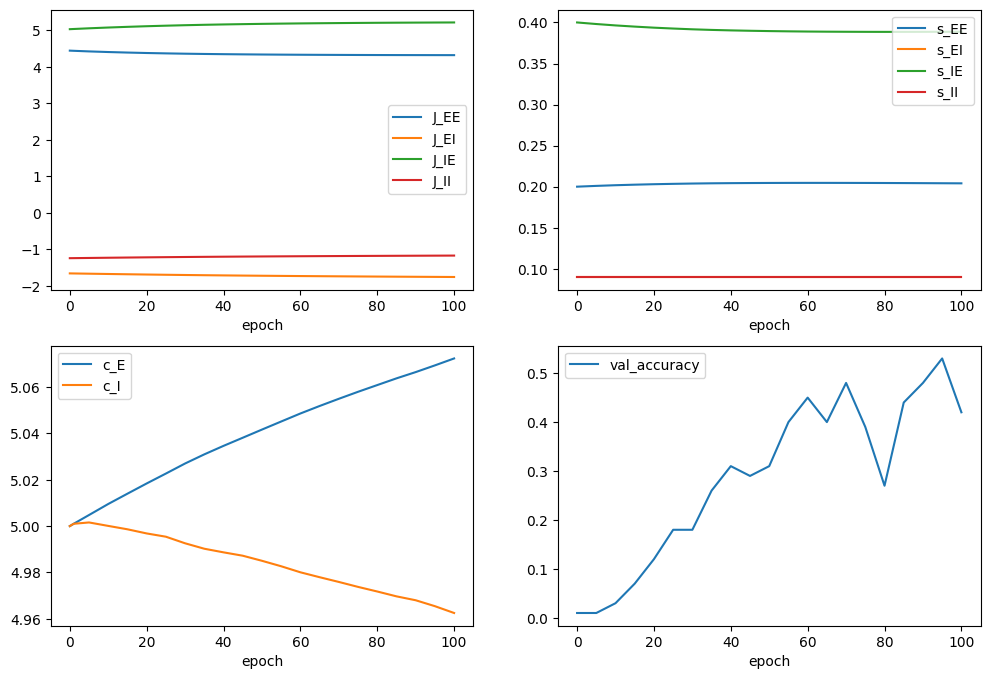

In [10]:
plot_results(results)

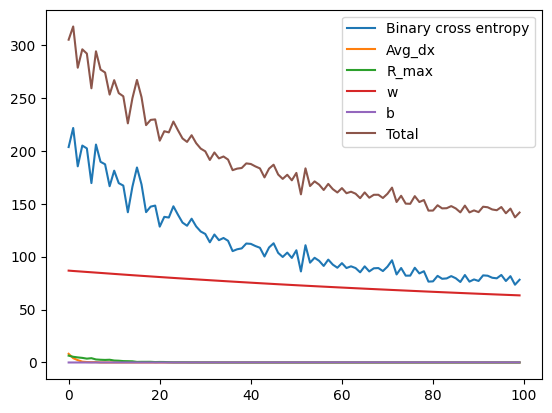

In [15]:
plt.plot(training_losses.T, label = ['Binary cross entropy', 'Avg_dx', 'R_max', 'w', 'b', 'Total'] )
plt.legend()
plt.show()

In [10]:
results = '/mnt/d/temp/ssn_modelling/ssn-simulator/results/regularizer_loss.csv'
new_pars, val_loss_per_epoch, training_losses = train_SSN_vmap(opt_pars, ssn_pars, grid_pars, conn_pars, stimuli_pars, filter_pars,  conv_pars, epochs_to_save = epochs_to_save, results_filename=results, ref_ori = 55, offset = 10, batch_size = 100, epochs = epochs)

Before training  -- loss: 2.3028900623321533, accuracy: 0.46000000834465027 
Training loss: 226.53993225097656 ¦ Validation -- loss: 2.2892532348632812, accuracy: 0.44999998807907104 at epoch 1, (time 29.951553344726562)
Training loss: 197.8055419921875 ¦ Validation -- loss: 2.05426025390625, accuracy: 0.5400000214576721 at epoch 5, (time 27.575343370437622)
Training loss: 204.68588256835938 ¦ Validation -- loss: 1.9359263181686401, accuracy: 0.5099999904632568 at epoch 10, (time 27.15265202522278)
Training loss: 186.83612060546875 ¦ Validation -- loss: 1.8548778295516968, accuracy: 0.5099999904632568 at epoch 15, (time 27.342909812927246)
Training loss: 172.61062622070312 ¦ Validation -- loss: 1.7948635816574097, accuracy: 0.5600000023841858 at epoch 20, (time 27.392860174179077)
Training loss: 178.8087158203125 ¦ Validation -- loss: 1.8103362321853638, accuracy: 0.4699999988079071 at epoch 25, (time 27.672823190689087)
Training loss: 172.00096130371094 ¦ Validation -- loss: 1.6261581

In [24]:
(J_2x2 / oldJ_2x2 - 1 ) * 100

DeviceArray([[1669.896  ,  -89.12499],
             [3253.433  ,  -75.73213]], dtype=float32)

In [22]:
new_pars['w_sig'] / opt_pars['w_sig']

DeviceArray([ 0.5431543 ,  0.57159305, -0.21853527,  0.54080737,
              0.7814081 ,  0.6302659 ,  0.49409202,  0.18212794,
              0.6969344 ,  0.86153877,  0.63862586, -8.436613  ,
              0.74484104,  0.59078634,  0.50237846,  0.41520897,
              0.7306901 ,  0.45415673,  0.87750304,  0.5562116 ,
              1.304275  ,  0.31671944,  3.922719  ,  2.400178  ,
              0.61103475], dtype=float32)

## INITIALIZATION HISTOGRAM

In [12]:
## PLOT INITIALIZATION HISTOGRAM
import numpy
from training_script import model
def vmap_eval2(opt_pars, ssn_pars, grid_pars, conn_pars, test_data, filter_pars,  conv_pars):
    '''
    For a given value of the weights, calculate the loss for all the stimuli.
    Output:
        losses: size(n_stimuli)
        Accuracy: scalar
    '''
    
    eval_vmap = vmap(model, in_axes = ({'b_sig': None, 'logJ_2x2': None, 'logs_2x2': None, 'w_sig': None, 'c_E':None, 'c_I':None}, None, None, {'PERIODIC': None, 'p_local': [None, None], 'sigma_oris': None},  {'ref':0, 'target':0, 'label':0}, {'conv_factor': None, 'degree_per_pixel': None, 'edge_deg': None, 'k': None, 'sigma_g': None}, {'Tmax': None, 'dt': None, 'silent': None, 'verbose': None, 'xtol': None}) )
    losses, pred_labels = eval_vmap(opt_pars, ssn_pars, grid_pars, conn_pars, test_data, filter_pars,  conv_pars)
        
    accuracy = np.sum(test_data['label'] == pred_labels)/len(test_data['label']) 
    
    return losses, accuracy

def vmap_eval3(opt_pars, ssn_pars, grid_pars, conn_pars, test_data, filter_pars,  conv_pars):
    '''
    Iterates through all values of 'w' to give the losses at each stimuli and weight, and the accuracy at each weight
    Output:
        losses: size(n_weights, n_stimuli )
        accuracy: size( n_weights)
    '''

    eval_vmap = vmap(vmap_eval2, in_axes = ({'b_sig': None, 'logJ_2x2': None, 'logs_2x2': None, 'w_sig': 0, 'c_E':None, 'c_I':None}, None, None, {'PERIODIC': None, 'p_local': [None, None], 'sigma_oris': None},  {'ref':None, 'target':None, 'label':None}, {'conv_factor': None, 'degree_per_pixel': None, 'edge_deg': None, 'k': None, 'sigma_g': None}, {'Tmax': None, 'dt': None, 'silent': None, 'verbose': None, 'xtol': None}) )
    losses, accuracies = eval_vmap(opt_pars, ssn_pars, grid_pars, conn_pars, test_data, filter_pars,  conv_pars)
    print(losses.shape)
    print(accuracies.shape)
    return losses, accuracies
    
    
def test_accuracies(opt_pars, ssn_pars, grid_pars, conn_pars, filter_pars,  conv_pars, stimuli_pars, trials = 5, p = 0.9, printing=True):
    
    key = random.PRNGKey(7)
    N_neurons = 25
    accuracies = []
    key, _ = random.split(key)
    opt_pars['w_sig'] = random.normal(key, shape = (trials, N_neurons)) / np.sqrt(N_neurons)
    
    train_data = create_data(stimuli_pars)
    
    print(opt_pars['w_sig'].shape)
    val_loss, accuracies = vmap_eval3(opt_pars, ssn_pars, grid_pars, conn_pars, train_data, filter_pars,  conv_pars)
    
    #calcualate how many accuracies are above 90
    higher_90 = np.sum(accuracies[accuracies>p]) / len(accuracies)

    if printing:
        print('grating contrast = {}, jitter = {}, noise std={}, acc (% >90 ) = {}'.format(stimuli_pars['grating_contrast'], stimuli_pars['jitter_val'], stimuli_pars['std'], higher_90))
    return higher_90, accuracies


def initial_acc( opt_pars, ssn_pars, grid_pars, conn_pars, filter_pars,  conv_pars, stimuli_pars, jitter_max,  std_max, p = 0.9):
    '''
    Find initial accuracy for varying jitter and noise levels. 
    
    '''

    
    list_noise  = np.linspace(20, std_max, 5)
    list_jitters = np.linspace(0, jitter_max, 5)
   
    
    low_acc=[]
    all_accuracies=[]
    
    
    for noise in list_noise:
        for jitter in list_jitters:
            
            stimuli_pars['std'] = noise
            stimuli_pars['jitter_val'] = jitter
            higher_90, acc = test_accuracies(opt_pars, ssn_pars, grid_pars, conn_pars, filter_pars, conv_pars, stimuli_pars, p=p,  trials=100, printing=False)
            
            #save low accuracies
            if higher_90 < 0.05:
                low_acc.append([jitter, noise, higher_90])

            all_accuracies.append([jitter, noise, acc])
    
    plot_histograms(all_accuracies)
        
    
    return all_accuracies, low_acc


def plot_histograms(all_accuracies):
    
    #n_rows =  int(np.sqrt(len(all_accuracies)))
    #n_cols = int(np.ceil(len(all_accuracies) / n_rows))
    n_cols = 5
    n_rows = 5
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 20))
    fig.subplots_adjust(wspace=0.5, hspace=0.5)

    count = 0

    
   #plot histograms
    for k in range(n_rows):
        for j in range (n_cols):
            axs[k,j].hist(all_accuracies[count][2])
            axs[k,j].set_xlabel('Initial accuracy')
            axs[k,j].set_ylabel('Frequency')
            axs[k,j].set_title('std = '+str(np.round(all_accuracies[count][1], 2))+ ' jitter = '+str(np.round(all_accuracies[count][0], 2)), fontsize=10)
            count+=1
            if count==len(all_accuracies):
                break
    
    fig.show()
    

(100, 25)
(100, 100)
(100,)
(100, 25)
(100, 100)
(100,)
(100, 25)
(100, 100)
(100,)
(100, 25)
(100, 100)
(100,)
(100, 25)
(100, 100)
(100,)
(100, 25)
(100, 100)
(100,)
(100, 25)
(100, 100)
(100,)
(100, 25)
(100, 100)
(100,)
(100, 25)
(100, 100)
(100,)
(100, 25)
(100, 100)
(100,)
(100, 25)
(100, 100)
(100,)
(100, 25)
(100, 100)
(100,)
(100, 25)
(100, 100)
(100,)
(100, 25)
(100, 100)
(100,)
(100, 25)
(100, 100)
(100,)
(100, 25)
(100, 100)
(100,)
(100, 25)
(100, 100)
(100,)
(100, 25)
(100, 100)
(100,)
(100, 25)
(100, 100)
(100,)
(100, 25)
(100, 100)
(100,)
(100, 25)
(100, 100)
(100,)
(100, 25)
(100, 100)
(100,)
(100, 25)
(100, 100)
(100,)
(100, 25)
(100, 100)
(100,)
(100, 25)
(100, 100)
(100,)


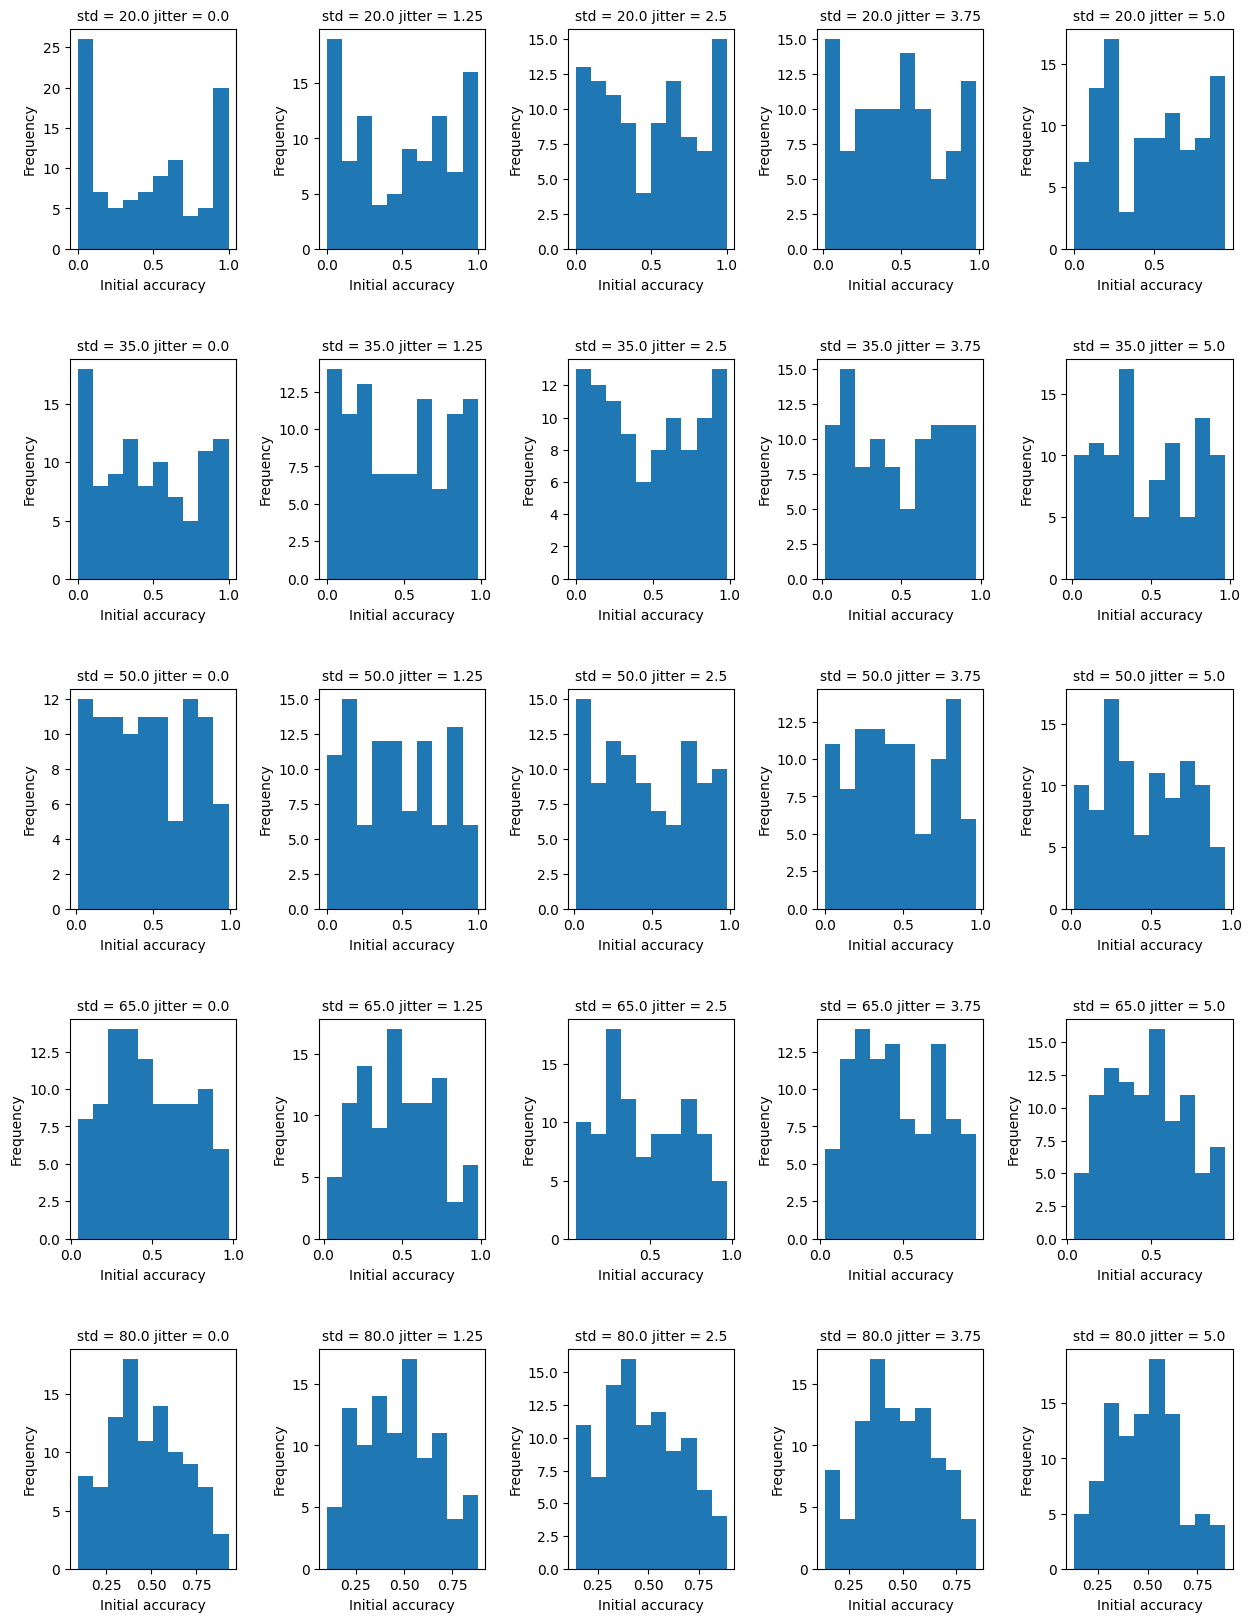

In [13]:

all_acc, low_acc = initial_acc( opt_pars, ssn_pars, grid_pars, conn_pars, filter_pars,  conv_pars, stimuli_pars, jitter_max = 5,  std_max = 80)

## PLOT RESULTS

In [ ]:
results_filename = '/mnt/d/temp/ssn_modelling/ssn-simulator/results/constant_set_5.csv'
results_filename2 = '/mnt/d/temp/ssn_modelling/ssn-simulator/results/constant_set_0.csv'
results_filename3 = '/mnt/d/temp/ssn_modelling/ssn-simulator/results/constant_set_0_Tmax200.csv'
results_filename4 = '/mnt/d/temp/ssn_modelling/ssn-simulator/results/constant_set_5_Tmax200.csv'
results_new_loss='/mnt/d/temp/ssn_modelling/ssn-simulator/results/test_new_loss.csv'
results_batch50 = '/mnt/d/temp/ssn_modelling/ssn-simulator/results/batch50_c_5_T400.csv'
new_results = '/mnt/d/temp/ssn_modelling/ssn-simulator/results/batch50_c_0_T200.csv'

In [ ]:
results_batch100_offset10 = '/mnt/d/temp/ssn_modelling/ssn-simulator/results/BATCH_100_offset10.csv'

In [5]:
results = '/mnt/d/temp/ssn_modelling/ssn-simulator/results/regularizer_loss.csv'
param_ratios(results)

Index(['J_EE', 'J_EI', 'J_IE', 'J_II'], dtype='object')
J ratios =  [-1  1  1 -1]
Index(['s_EE', 's_EI', 's_IE', 's_II'], dtype='object')
[1.01241220062061 1.0 0.9875357499999999 1.0]
s ratios =  [ 1  0 -1  0]


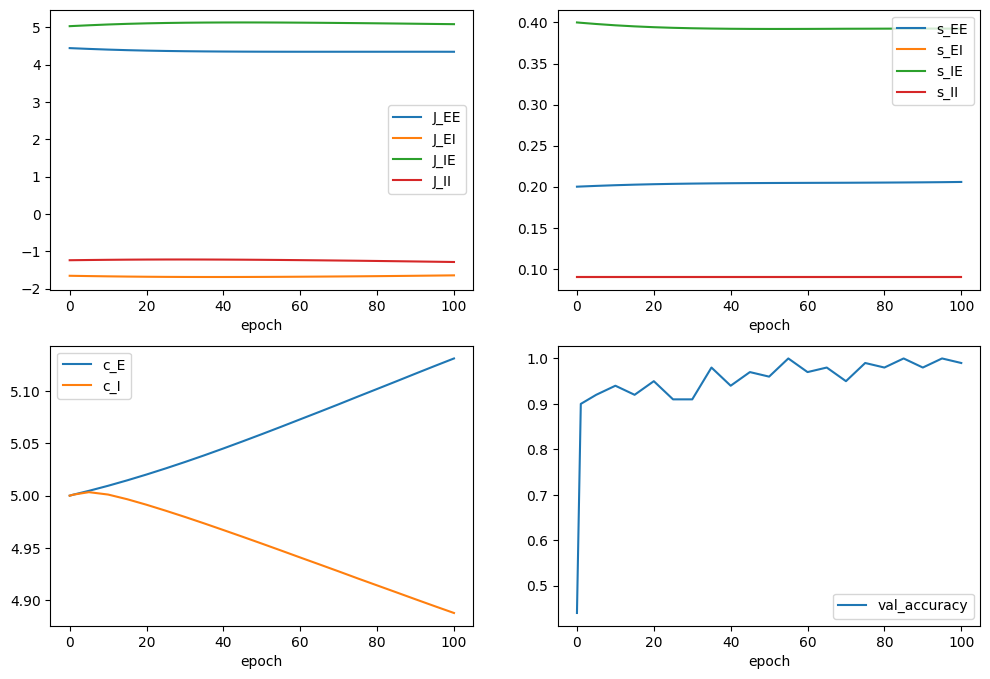

In [14]:
plot_results(results_w0)

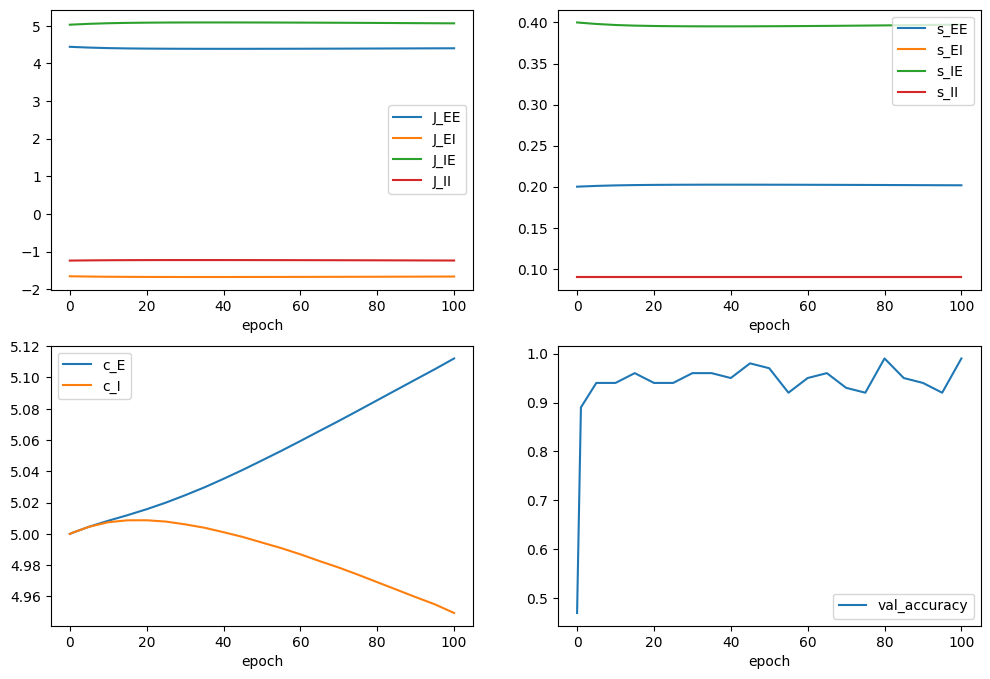

In [13]:
plot_results(noisy_results)

In [ ]:
plot_results(results_batch100_offset10_w3)

## Proof of concept model

In [ ]:
def make_log_J_2x2(Js0):
    make_J2x2 = lambda Jee, Jei, Jie, Jii: np.array([[Jee, -Jei], [Jie,  -Jii]]) * np.pi * ssn_pars.psi
    J_2x2 = make_J2x2(*Js0)
    signs=np.array([[1, -1], [1, -1]])
    logJ_2x2 =np.log(J_2x2*signs)
    
    return logJ_2x2

In [ ]:
def create_new_pars(o_Js0, position, value, params):
    
    Js0 = o_Js0.copy()
    Js0[position] = Js0[position]*value
    #print(Js0[position])
    updated_params = params.copy()
    logJ_2x2 = make_log_J_2x2(Js0)
    updated_params['logJ_2x2'] = logJ_2x2
    
    return updated_params

1. Create results file

In [ ]:
#Name of results csv
home_dir = os.getcwd()
#Create directory for results
results_dir = os.path.join(home_dir, 'results')
if os.path.exists(results_dir) == False:
        os.makedirs(results_dir)
        
        
results_name = 'proof.csv' #SPECIFY NAME OF RESULTS FILE
if results_name == None:
    results_name = 'results_test2.csv'

results_filename = os.path.join(results_dir, results_name)
results_handle = open(results_filename, 'w')

#results_writer = csv.DictWriter(results_handle, fieldnames=save_params.keys())
#results_writer.writeheader()

In [ ]:
def save_params(new_pars, test_accuracy, results_handle, header=False):
    save_params= dict(val_accuracy= test_accuracy, 
    J_EE= new_pars['logJ_2x2'][0,0], J_EI = new_pars['logJ_2x2'][0,1], 
                  J_IE = new_pars['logJ_2x2'][1,0], J_II = new_pars['logJ_2x2'][1,1])
    
    if header==True:
        results_writer = csv.DictWriter(results_handle, fieldnames=save_params.keys())
        results_writer.writeheader()
    
    
    results_writer.writerow(save_params)       

1. Redefine parameters

In [ ]:
# Caleb's params for the full (with local) model:
o_Js0 = [1.82650658, 0.68194475, 2.06815311, 0.5106321]
gE, gI = 0.57328625, 0.26144141

sigEE, sigIE = 0.2, 0.40
sigEI, sigII = .09, .09


make_J2x2 = lambda Jee, Jei, Jie, Jii: np.array([[Jee, -Jei], [Jie,  -Jii]]) * np.pi * ssn_pars.psi
J_2x2 = make_J2x2(*o_Js0)
s_2x2 = np.array([[sigEE, sigEI],[sigIE, sigII]])

#Positive reparameterization
signs=np.array([[1, -1], [1, -1]])
logJ_2x2 =np.log(J_2x2*signs)


#Optimization pars
opt_pars = dict(logJ_2x2 = logJ_2x2, logs_2x2 = logs_2x2, w_sig = w_sig, b_sig=b_sig, c_E = c_E, c_I = c_I)
opt_pars['logJ_2x2']

2. Generate testing data

In [ ]:
ref_ori = 55
offset = 10
batch_size = 200
test_data = create_data(stimuli_pars, number = batch_size, offset = offset, ref_ori = ref_ori)

3. Evaluate original model

In [ ]:
_, test_accuracy, _ = vmap_eval(opt_pars, ssn_pars, grid_pars, conn_pars, test_data, filter_pars,  conv_pars)
test_accuracy

--> Edit parameters

J_EE

In [ ]:
new_pars = create_new_pars(o_Js0, 0, 0.8, opt_pars)
_, test_accuracy, _ = vmap_eval(new_pars, ssn_pars, grid_pars, conn_pars, test_data, filter_pars,  conv_pars)
print(test_accuracy)

#save_params(new_pars, test_accuracy, results_handle, header = True)
new_pars = create_new_pars(o_Js0, 0, 1.2, opt_pars)
_, test_accuracy, _ = vmap_eval(new_pars, ssn_pars, grid_pars, conn_pars, test_data, filter_pars,  conv_pars)
print(test_accuracy)

J_EI

In [ ]:
new_pars = create_new_pars(o_Js0, 1, 0.8, opt_pars)
_, test_accuracy_1, _ = vmap_eval(new_pars, ssn_pars, grid_pars, conn_pars, test_data, filter_pars,  conv_pars)
print(test_accuracy_1)

new_pars = create_new_pars(o_Js0, 1, 1.2, opt_pars)
_, test_accuracy_2, _ = vmap_eval(new_pars, ssn_pars, grid_pars, conn_pars, test_data, filter_pars,  conv_pars)
print(test_accuracy_2)

J_IE

In [ ]:
new_pars = create_new_pars(o_Js0, 2, 0.8, opt_pars)
_, test_accuracy_1, _ = vmap_eval(new_pars, ssn_pars, grid_pars, conn_pars, test_data, filter_pars,  conv_pars)
print(test_accuracy_1)

new_pars = create_new_pars(o_Js0, 2, 1.2, opt_pars)
_, test_accuracy_2, _ = vmap_eval(new_pars, ssn_pars, grid_pars, conn_pars, test_data, filter_pars,  conv_pars)
print(test_accuracy_2)

J_II

In [ ]:
new_pars = create_new_pars(o_Js0, 3, 0.8, opt_pars)
_, test_accuracy_1, _ = vmap_eval(new_pars, ssn_pars, grid_pars, conn_pars, test_data, filter_pars,  conv_pars)
print(test_accuracy_1)

new_pars = create_new_pars(o_Js0, 3, 1.2, opt_pars)
_, test_accuracy_2, _ = vmap_eval(new_pars, ssn_pars, grid_pars, conn_pars, test_data, filter_pars,  conv_pars)
print(test_accuracy_2)

In [11]:
key_int = numpy.random.randint(low=0, high=10000)
key = random.PRNGKey(key_int)
for i in range(0,100):
        #key_int = numpy.random.randint(low=0, high=10000)
        all_pred.append( np.sum(jax.random.bernoulli(key = key, p=0.5, shape=None)))
        key, _ = random.split(key)
print(np.sum(np.asarray(all_pred)))

245


In [58]:
key = random.PRNGKey(9)
np.sum(jax.random.bernoulli(key = key, p=0.9, shape=None))

DeviceArray(1, dtype=int32)